In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import math, json, os, sys

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.optimizers import Adam, SGD
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [3]:
keras.backend.backend()

'tensorflow'

In [4]:
keras.backend.image_dim_ordering()

'tf'

In [5]:
keras.__version__

'2.2.2'

In [6]:
DATA_DIR = 'C:\\Users\\rutuj\\Desktop\\Fall18\\ML\\Classification\\10-monkey-species\\data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training')
VALID_DIR = os.path.join(DATA_DIR, 'validation')
SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
num_train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
num_valid_samples = sum([len(files) for r, d, files in os.walk(VALID_DIR)])

num_train_steps = math.floor(num_train_samples/BATCH_SIZE)
num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)

In [8]:
print(num_train_samples)
print(num_valid_samples)
print(num_train_steps)
print(num_valid_steps)

1098
272
34
8


### Keras data generators 

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 10,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size = BATCH_SIZE,
    target_size = SIZE,
    class_mode = 'categorical',
    shuffle = True)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    batch_size = BATCH_SIZE,
    target_size = SIZE,
    class_mode = 'categorical',
    shuffle = True)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Using weights of ResNet trained on imagenet

In [10]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\keras_applications\resnet50.py:264: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


NOTE: Keras removed the Average pooling layer from ResNet50, 
so we have to add a GlobalAveragePooling Layer 
before we attach a fully connected network at the tail.

In [11]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)

# attaching fully connected layers at the tail.
# final dense layer has 10 neurons as we have 10 classes.
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(10, activation='softmax')(x)
model = Model(inputs = conv_base.input, outputs = predictions)

In [49]:
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### Model Training

NOTE: TensorBoard Callbacks don't work with fit_generator

In [58]:
#tbCallback = keras.callbacks.TensorBoard(log_dir='C:\\Users\\rutuj\\Desktop\\Fall18\\ML\\Classification\\10-monkey-species\\Graph', histogram_freq=1, write_graph=True, write_images=True)
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch = num_train_steps,
                              epochs = 50,
                              validation_steps = num_valid_steps,
                              validation_data = validation_generator,
                              #callbacks = [tbCallback]
                             )

Epoch 1/50
34/34 [==============================] - 49s 1s/step - loss: 0.1442 - acc: 0.9503 - val_loss: 0.1270 - val_acc: 0.9542
Epoch 2/50
34/34 [==============================] - 48s 1s/step - loss: 0.1460 - acc: 0.9444 - val_loss: 0.3609 - val_acc: 0.9125
Epoch 3/50
34/34 [==============================] - 48s 1s/step - loss: 0.1341 - acc: 0.9595 - val_loss: 0.2566 - val_acc: 0.9333
Epoch 4/50
34/34 [==============================] - 56s 2s/step - loss: 0.1359 - acc: 0.9513 - val_loss: 0.1783 - val_acc: 0.9667
Epoch 5/50
34/34 [==============================] - 52s 2s/step - loss: 0.1398 - acc: 0.9504 - val_loss: 0.2834 - val_acc: 0.9219
Epoch 6/50
34/34 [==============================] - 51s 1s/step - loss: 0.1748 - acc: 0.9338 - val_loss: 0.1514 - val_acc: 0.9667
Epoch 7/50
34/34 [==============================] - 51s 1s/step - loss: 0.0723 - acc: 0.9724 - val_loss: 0.2724 - val_acc: 0.9417
Epoch 8/50
34/34 [==============================] - 51s 2s/step - loss: 0.1115 - acc: 0.96

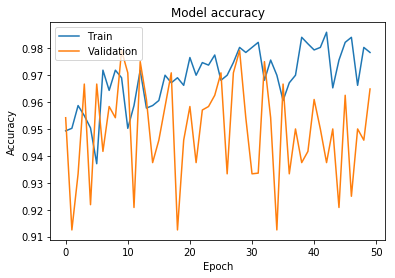

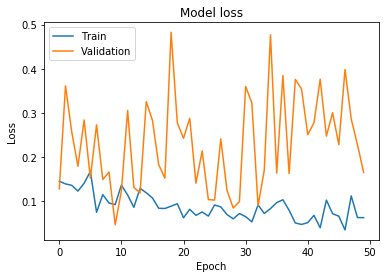

In [59]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Save and load the fine-tuned model

In [14]:
# architecture and weights to HDF5
#model.save('models/resnet-adam/model.h5')

# architecture to JSON, weights to HDF5
#model.save_weights('models/resnet-adam/weights.h5')
#with open('models/resnet-adam/architecture.json', 'w') as f:
        #f.write(model.to_json())

In [15]:
# architecture and weights from HDF5
#model = load_model('models/resnet-adam/model.h5')

# architecture from JSON, weights from HDF5
#with open('models/resnet-adam/architecture.json') as f:
    #model = model_from_json(f.read())
#model.load_weights('models/resnet-adam/weights.h5')

### Predictions on test images

In [60]:
validation_img_paths = ["data/test/n0018.jpg",
                        "data/test/n018.jpg",
                        "data/test/n4016.jpg",
                        "data/test/n4017.jpg",
                        "data/test/dummy1.jpg",
                        "data/test/n0dummy.jpg",
                        "data/test/n6dummy.jpg"
                       ]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [61]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [62]:
pred_probs = model.predict(validation_batch)

In [63]:
pred_probs[0]

array([1.0000000e+00, 3.0164326e-18, 1.3581731e-12, 3.5253509e-21,
       3.3132385e-14, 4.1230973e-12, 2.5495266e-18, 3.5009290e-16,
       5.7211038e-11, 1.1229963e-09], dtype=float32)

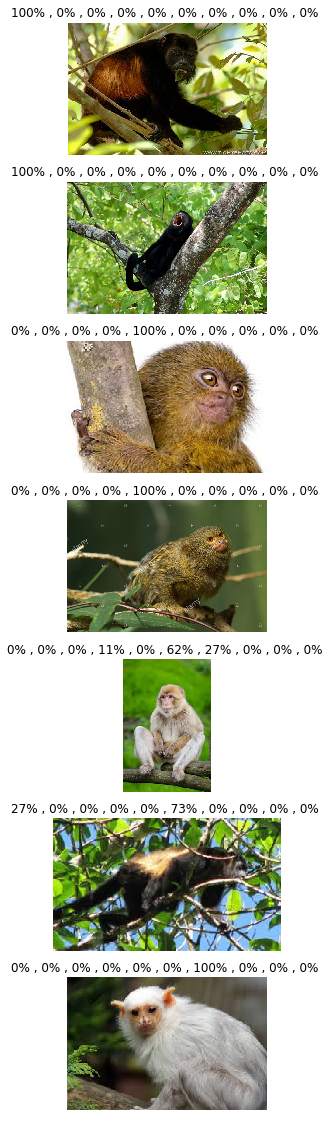

In [64]:
fig, axs = plt.subplots(len(img_list), 1, figsize=(20, 20))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% "
                 .format(100*pred_probs[i,0], 
                         100*pred_probs[i,1],
                         100*pred_probs[i,2],
                         100*pred_probs[i,3],
                         100*pred_probs[i,4],
                         100*pred_probs[i,5],
                         100*pred_probs[i,6],
                         100*pred_probs[i,7],
                         100*pred_probs[i,8],
                         100*pred_probs[i,9]
                        ))
    ax.imshow(img)